# Exercise Sheet 4

In [1]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0, 4.0)
matplotlib.rcParams['savefig.dpi'] = 200
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division
import numpy as np
import pyNN.nest as sim

CSAConnector: libneurosim support not available in NEST.
Falling back on PyNN's default CSAConnector.
Please re-compile NEST using --with-libneurosim=PATH


In [2]:
E_l = -50
C_m = 1
v = -40
rho = -50
tau_syn = 5

## 4.1 COBA LIF

In [47]:
neuron_parameters={
    'v_rest'     : -50.0,
    'cm'         : 1,
    'tau_m'      : 1.0,
    'tau_syn_E'  : 5.0,
    'tau_syn_I'  : 5.0,
    'i_offset'   : 0.0,
    'v_reset'    : -50.0,
    'v_thresh'   : -40.0,
    'e_rev_E'    : 0,
    'e_rev_I'     : -100,
}
t_sim = 1000.
f = 100
sim.setup(timestep=0.1, min_delay=0.1)
poisson = sim.Population(1, sim.SpikeSourcePoisson(rate=f, start=0.0, duration=t_sim))
pop = sim.Population(1, sim.IF_cond_exp(**neuron_parameters))
pop.record_v()
pop.record_gsyn()
sim.Projection(poisson, pop, connector=sim.OneToOneConnector(),
            synapse_type=sim.StaticSynapse(weight=0.1),
            receptor_type='excitatory')
sim.Projection(poisson, pop, connector=sim.OneToOneConnector(),
            synapse_type=sim.StaticSynapse(weight=0.1),
            receptor_type='inhibitory')
sim.run(t_sim)
v = pop.get_data('v')
gsyn = pop.get_data('gsyn')
sim.end()

(array([  2.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          3.00000000e+00,   4.00000000e+00,   7.00000000e+00,
          9.97700000e+03]),
 array([-65. , -63.5, -62. , -60.5, -59. , -57.5, -56. , -54.5, -53. ,
        -51.5, -50. ]),
 <a list of 10 Patch objects>)

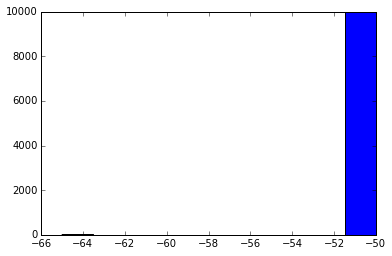

In [48]:
plt.hist(v.segments[0].analogsignalarrays[0])

In [36]:
gsyn.segments[0]

Segment with 
name: 'segment000'
description: u'Population "population206"\n    Structure   : Line\n      y: 0.0\n      x0: 0.0\n      z: 0.0\n      dx: 1.0Local cells : 1\n    Cell type   : IF_cond_exp\n    ID range    : 7-7\n    First cell on this node:\n      ID: 7\n      '

what's the problem here?

## 4.2 f-I curves

In [3]:
def sim_rate(I, tau_ref, t_sim=1000.):
    neuron_parameters={
            'v_rest'     : -50.0,
            'cm'         : 1,
            'tau_m'      : 1.0,
            'tau_syn_E'  : 5.0,
            'tau_syn_I'  : 5.0,
            'i_offset'   : 0.0,
            'v_reset'    : -50.0,
            'v_thresh'   : -40.0,
        }
    sim.setup(timestep=min(0.1, tau_ref), min_delay=0.1)
    pulse = sim.DCSource(amplitude=I, start=0.0, stop=t_sim)
    pop = sim.Population(1, sim.IF_curr_exp(tau_refrac=tau_ref, **neuron_parameters))
    pop.record('spikes')
    pulse.inject_into(pop)
    sim.run(t_sim)
    rate = len(pop.get_data('spikes').segments[0].spiketrains[0]) / t_sim * 1000.
    sim.end()
    return rate

/Users/knl/.virtualenvs/bic/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
/Users/knl/.virtualenvs/bic/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log


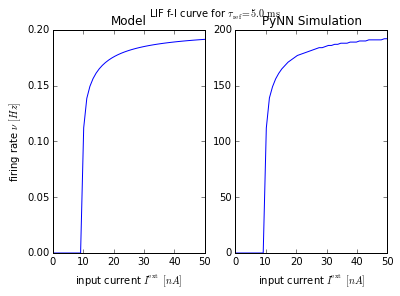

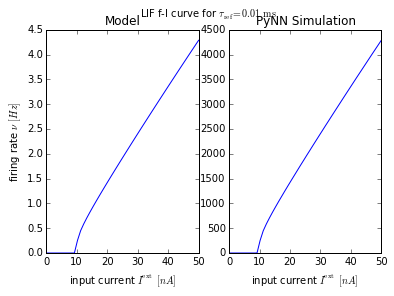

In [5]:
I = np.linspace(0,50,50)
f = lambda I, tau_ref: (tau_ref + tau_m * np.log((rho-E_l-I/g_l)/(v-E_l-I/g_l)))**-1
for tau_ref in [5., 0.01]:
    plt.figure()
    plt.suptitle(ur'LIF f-I curve for $\tau_{\mathrm{ref}}='+str(tau_ref)+'\,\mathrm{ms}$')

    tau_m = 1
    g_l = C_m/tau_m
    plt.subplot(1, 2, 1)
    plt.title('Model')
    rates = f(I,tau_ref)
    rates[np.isnan(rates)] = 0
    plt.plot(I,rates)
    plt.ylabel(ur'firing rate $\nu \, [Hz]$')
    plt.xlabel(ur'input current $I^{\mathrm{ext}} \, [nA]$')   
    
    rates = np.zeros(len(I))
    for (i,current) in enumerate(I):
        rates[i] = sim_rate(I=current, tau_ref=tau_ref)
    plt.subplot(1, 2, 2)
    plt.title('PyNN Simulation')
    plt.plot(I,rates)
    plt.xlabel(ur'input current $I^{\mathrm{ext}} \, [nA]$')